<a href="https://colab.research.google.com/github/DAVIDCRUZ0202/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_221_assignment_David_Cruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [2]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [5]:
# Still Need to Separate Train/Validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

######## read train_test_split.stratify, and define statistical stratification
# Stratify is used to correctly split a data set.

((47520, 41), (11880, 41), (14358, 40))

#### Above you can see the shapes of the train/validate/test split

In [40]:
# One thing I know we do before splitting data is getting a baseline.

train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

### So we need to beat the baseline of 54% in our test data.

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
import numpy as np
### Here is a useful function to "wrangle" train, validate, and test sets in the
### same way. We will save many drops of code by combining all of the manual steps into
### one function.

### First, we define the function and give it a description:

def wrangle(X):
    """ 'Wrangle' train, validate, and test sets in the same way"""
    # This line will prevent SettingWithCopyWarning
    X = X.copy()

    #let's correct some of the issues in our pandas report. Beginning with Latitude,
    # we will correct the small values near zero with an actual 0.

    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    ## Now we will get our code ready for imputation by replacing all 0's with
    ## np.nan values. In this case, we'll make a list of columns with 0's, then
    ## make a quick function to replace the 0's in those columns with np.nan.

    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)

    ### in this data set, quantity & quantity_group are duplicates, so we drop one
    X = X.drop(columns='quantity_group')

    # return the "wrangled" dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

### Above, we apply our wrangle() function to the separated lists which we'll
### work with. What is the difference between wrangling the whole data set and 
### wrangling the sublists?

In [0]:
#### Why do we clean train/val/test with one function, if we could just clean
#### the one data set with one function, before splitting?

In [17]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <=50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# combine lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
# We don't make a y_test here , because we don't have the data for our y_test. 
# This data set came ready for actual testing, because we will be training and 
# validating our model, we will only do the test one single time, and it will be 
# through the form of a model.predict. We will submit that prediction to Kaggle.



In [0]:
## The purpose of making a pipeline , is to condense multiple paragraphs of code
## into one easy to use command. This gives me the power to transform my data
## with any combination of transformers. The output is readiy to be interpreted,
## graphed, and evaluated by training data, and validation data. The purpose of 
## having a pipeline is to have a sort of glossary as to what your model is doing to 
## your data. It's ready to do the pipeline.fit, it's ready to do validation
## pipeline.score accuracy checks, and it's ready to be predicted on by our pipeline.predict. 

In [0]:
from sklearn.tree import DecisionTreeClassifier



### Below we can see the validation score

In [24]:


pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

### Pipeline has commands just like models. Fit the pipeline on the train!!!
pipeline.fit(X_train, y_train)

# Score on val
print(('Validation Accuracy'), pipeline.score(X_val, y_val))

# predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.7594276094276095


In [0]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = pipeline.predict(X_test)


# Makes a dataframe with two columns, id and status_group(AKA Target) 
# and writes to a csv file, without the index

submission = sample_submission.copy()

submission['status_group'] = y_pred

submission.to_csv('dc_try1.csv', index=False)

In [0]:
from google.colab import files
files.download('dc_try1.csv')

### Below you can see feature importance

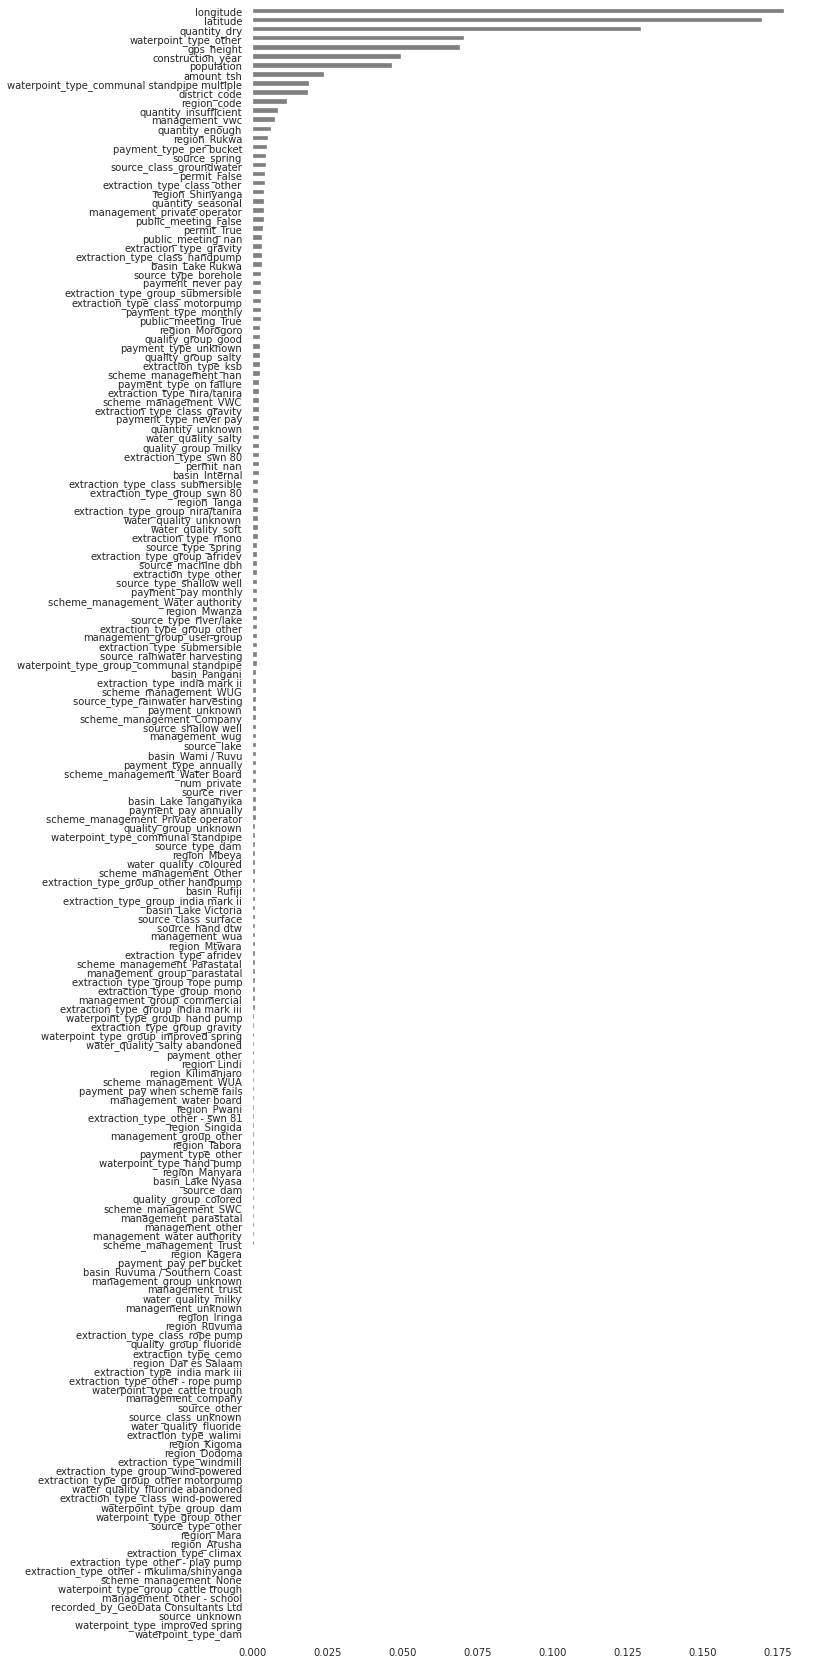

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');